In [1]:
import urllib
import pyodbc
import itertools
import pandas as pd
import numpy as np
import seaborn as sns
import sqlalchemy as sqla
import matplotlib as mpl
import statsmodels.api as sm
import multiprocessing as mp

from multiprocessing import Process
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm
from importlib import reload
from scipy import stats
from statsmodels.stats.contingency_tables import Table2x2 as ctable

In [2]:
with open('dbmi-aetna-cxn-str') as f:
    cxn_params = f.read().strip()
    gmw_cxn_str = urllib.parse.quote_plus(cxn_params + 'Database=gmw3')
    aetna_raw_cxn_str = urllib.parse.quote_plus(cxn_params + 'Database=AetnaDataWarehouse')
    hy_cxn_str = urllib.parse.quote_plus(cxn_params + 'Database=hy180')
    
engine = sqla.create_engine("mssql+pyodbc:///?odbc_connect=%s" % gmw_cxn_str, connect_args = {'autocommit':True})
cxn = engine.connect()
ins = sqla.inspect(engine)

hy_engine = sqla.create_engine("mssql+pyodbc:///?odbc_connect=%s" % hy_cxn_str, connect_args = {'autocommit': True, 'fast_executemany': True}, pool_size=100)
hy_cxn = hy_engine.connect()

# Glucose tests per age 

## Data

In [72]:
# temp table for glucose tests per patient
glucose_tests_cpt = ('82947', )
glucose_panels_cpt = ('80047', '80048', '80053', '80069')
a1c_tests_cpt = ('83036', )
all_tests_cpt = glucose_tests_cpt + glucose_panels_cpt + a1c_tests_cpt

tmp_query = ("drop table if exists #hytmp; drop table if exists #patientBYCount;"
            " select MemberNum, datepart(yyyy, DateServiceStarted) as year, LineLevelProcedureCode as cpt "
            "  into #hytmp from ObservationProcedure with (nolock) "
           f"  where LineLevelProcedureCodeType='C' and LineLevelProcedureCode in {str(all_tests_cpt)};"
            " select BirthYearMinus1900, count(*) as byearCount"
            "  into #patientBYCount"
            "  from gmw3.dbo.Member"
            "  group by BirthYearMinus1900")
cxn.execute(tmp_query)

# count glucose measurements in each byear bucket per year
query = ("select t2.year, (1. * count(*))/byearCount as testsPerBY, 119 - t1.BirthYearMinus1900 as age"
        " from Member as t1 "
        " join #hytmp as t2 on t1.MemberNum=t2.MemberNum"
        " join #patientBYCount as t3 on t1.BirthYearMinus1900=t3.BirthYearMinus1900"
        " group by year, t1.BirthYearMinus1900, byearCount;")
glucose_per_year = pd.read_sql(query, cxn)
glucose_per_year.to_csv('figdata/glucose_per_year.csv')

## Figure

Text(0, 0.5, 'glucose tests per member in 2011')

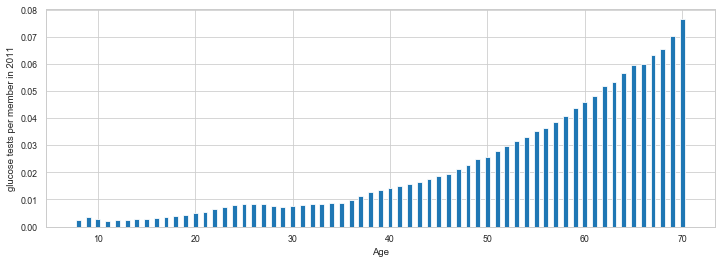

In [74]:
glucose_per_year = pd.read_csv('figdata/glucose_per_year.csv')

age_thres = 71
year = 2011

data = glucose_per_year.loc[(glucose_per_year.year == year) & (glucose_per_year.age < age_thres)].sort_values(by='age', ascending=True)

fig = plt.figure(figsize=(12, 4))
ax = plt.subplot(111)
bars = ax.bar(x=data.age.values, height=data.testsPerBY, align='center', width=.5)

plt.xlabel('Age')
plt.ylabel('glucose tests per member in 2011')

# Age distributions

## Data

In [50]:
def age_counts(group_table=None, cxn=cxn):
    if group_table is None:
        query = ("select 119 - BirthYearMinus1900 as age, count(*) as ageCount"
                " from gmw3.dbo.Member"
                " group by BirthYearMinus1900")
    else:
        query = ("select 119 - BirthYearMinus1900 as age, count(*) as ageCount"
                " from gmw3.dbo.Member as t1"
                " inner join %s as t2"
                " on t1.MemberNum=t2.MemberNum"
                " group by BirthYearMinus1900"
                % group_table)
    
    results = pd.read_sql(query, cxn)
    return results

In [75]:
groups = ['hy180.dbo.t2dCaseEmerge', 'hy180.dbo.t2dControlEmerge', 'hy180.dbo.t2dControlEmergeIgnoreLabValue', 'hy180.dbo.t2dControlEmergeIgnoreLab', 'hy180.dbo.t2dControlEmergeNoLab', 'hy180.dbo.t2dControlEmergeNoLabMatched']
labels = ['Case', 'Baseline Control', 'Ignore Lab Value', 'Ignore Lab', 'No Lab', 'No lab matched']

data = pd.DataFrame(columns=['age', 'ageCount', 'label'])
for group, label in zip(groups, labels):
    dist = age_counts(group)
    dist['label'] = label
    data = pd.concat([data, dist])
    
data.to_csv('figdata/age_distributions.csv')

## Figure

In [48]:
def age_histogram(results, ax=None, label_axes=True, **plot_params):
    if not ax: ax = plt.subplot(111)
    ax.bar(x=results.age.values, height=results.ageCount, **plot_params)
    if label_axes:
        ax.set_xlabel('Age')
        ax.set_ylabel('Count')

<Figure size 432x288 with 0 Axes>

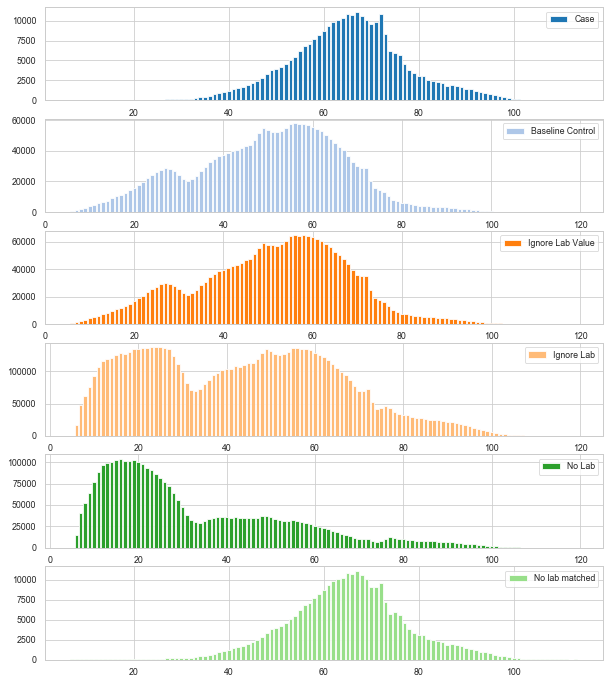

In [76]:
data = pd.read_csv('figdata/age_distributions.csv')

fig = plt.figure()
f, axes = plt.subplots(6, 1, figsize=(10, 12))
labels = ['Case', 'Baseline Control', 'Ignore Lab Value', 'Ignore Lab', 'No Lab', 'No lab matched']
cmap = mpl.cm.tab20

sns.set_context('paper')
sns.set_style('white')
for i, (ax, label) in enumerate(zip(axes, labels)):
    dist = age_histogram(results=data[data.label==label], ax=ax, label_axes=False, color=cmap(i))
    ax.legend([label])

# Association ORs

## Data

In [70]:
matched_results = pd.read_csv('results/matched_control_definitions_bootstrap.csv')
matched_results['matching'] = 'age and gender'
unmatched_results = pd.read_csv('results/control_definitions_bootstrap.csv')
unmatched_results['matching'] = 'none'

results = pd.concat([unmatched_results, matched_results], join='inner')
results['p < .05'] = results.p_value < .05
results['ci_width'] = results.ci95_upper - results.ci95_lower

## Figure

<Figure size 864x288 with 0 Axes>

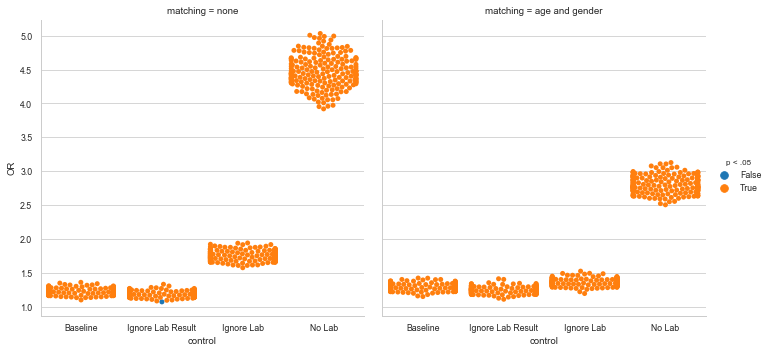

In [71]:
plt.figure(figsize=(12, 4))
sns.set_context('paper')
sns.set_style('whitegrid')
ax = sns.catplot(data=results[results.samp_size==10000], x='control', y='OR', hue='p < .05', col='matching', kind='swarm', order=['t2dControlEmerge', 't2dControlEmergeIgnoreLabValue', 't2dControlEmergeIgnoreLab', 't2dControlEmergeNoLab'])
ax.set_xticklabels(['Baseline', 'Ignore Lab Result', 'Ignore Lab', 'No Lab'], ha='center')

# Demographics

In [99]:
def default_enroll_window_agg(select_cols,
                          claims_table, 
                          claim_date_col,
                          group_by_col='MemberNum',
                          enrollment_table='hy180.dbo.EnrollFourPlusYears', 
                          window_date_col='enrollDatePlusFourYears',
                          enroll_date_col='enrollDate',
                          join_col='MemberNum'):
    
    select_cols.append(f't1.{join_col}')
    return (f"select {','.join(select_cols)}"
       f" from {claims_table} as t1 inner join {enrollment_table} as t2"
       f" on t1.{join_col}=t2.{join_col}"
       f" where {claim_date_col} between {enroll_date_col} and {window_date_col}"
       f" group by t1.{group_by_col}")

In [101]:
groups = ['hy180.dbo.t2dCaseEmerge', 'hy180.dbo.t2dControlEmerge', 'hy180.dbo.t2dControlEmergeIgnoreLabValue', 'hy180.dbo.t2dControlEmergeIgnoreLab', 'hy180.dbo.t2dControlEmergeNoLab', 'hy180.dbo.t2dControlEmergeNoLabMatched']

rows = []
for group in groups:
    num_members = cxn.execute(f'select count(*) from {group}').fetchone()[0]
    num_males = cxn.execute(f"select count(*) from {group} as t1 join Member as t2 on t1.MemberNum=t2.MemberNum where gender='M'").fetchone()[0]
    num_females = cxn.execute(f"select count(*) from {group} as t1 join Member as t2 on t1.MemberNum=t2.MemberNum where gender='F'").fetchone()[0]
    age_mean, age_std = cxn.execute(f"select avg(age), stdev(age) from {group} as t1 join (select MemberNum, 119 - Birthyearminus1900 as age from Member) as t2 on t1.MemberNum=t2.MemberNum").fetchone()
    num_with_depression = cxn.execute(f"select count(*) from {group} as t1 join hy180.dbo.depressionCase as t2 on t1.MemberNum=t2.MemberNum").fetchone()[0]
    fact_count_mean, fact_count_std = cxn.execute(f"select avg(factCount) / 4. as mean, stdev(factCount / 4.) as std from ({default_enroll_window_agg(['count(*) as factCount'], 'ObservationDiagnosis', 'StartDate')}) as t inner join {group} as t1 on t.MemberNum=t1.MemberNum").fetchone()
    rows.append((group, num_members, num_males, num_females, age_mean, age_std, num_with_depression, fact_count_mean, fact_count_std))
    
demographics = pd.DataFrame(columns=['group', 'num_members', 'num_males', 'num_females', 'age_mean', 'age_std', 'num_with_depression', 'fact_count_mean', 'fact_count_std'], data=rows)
    

In [89]:
demographics.T

group,hy180.dbo.t2dCaseEmerge,hy180.dbo.t2dControlEmerge,hy180.dbo.t2dControlEmergeIgnoreLabValue,hy180.dbo.t2dControlEmergeIgnoreLab,hy180.dbo.t2dControlEmergeNoLab,hy180.dbo.t2dControlEmergeNoLabMatched
num_members,289113.000000,2.288032e+06,2.547932e+06,8.062907e+06,3.397361e+06,285112.000000
num_males,151832.000000,9.863950e+05,1.114876e+06,3.877677e+06,1.766993e+06,147836.000000
num_females,137278.000000,1.301602e+06,1.433015e+06,4.185117e+06,1.630311e+06,137276.000000
age_mean,65.000000,4.900000e+01,5.000000e+01,4.300000e+01,3.200000e+01,65.000000
age_std,12.191594,1.672228e+01,1.689167e+01,2.185565e+01,2.085882e+01,12.247097
num_with_depression,47359.000000,3.164590e+05,3.585090e+05,8.031810e+05,1.422510e+05,18819.000000
